In [2]:
## import libraries
import sys
import glob
import re

import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec

# cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, plot_terrain
from utils import roundPartial, select_months_ds
import customcmaps as ccmap

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [3]:
path_to_data = '/data/projects/Comet/cwp140/' 
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [4]:
## Load Basin watershed file
fp = path_to_data + 'downloads/UpperCO/Upper_Colorado_River_Basin_Boundary/Upper_Colorado_River_Basin_Boundary.shp'
basin = gpd.read_file(fp, crs="EPSG:4326") # have to manually set the projection
basin

## get list of HUC8s within Upper Colorado River Basin
# test = gpd.clip(polys, basin)
# test.plot()

,EXT_ID,EXT_TYP_ID,NAME,geometry
0,9389,5.00,Upper Colorado Region,"POLYGON ((-106.65587 40.51559, -106.65376 40.5..."


In [5]:

def calc_fraction(ds1, ds2, varname, thres):
    
    ## total extreme precip
    total_prec = ds2.prec.sum('date').values
    ct_prec = ds2.prec.count('date').values
    
    ## get all the dates from the trajectory dataset where criteria is met
    ar_days = ds1.where(ds1[varname] >= float(thres), drop=True).start_date.values
    
    ## select those dates from precip dataset
    ds2 = ds2.sel(date=ar_days)
    
    ## calculate fraction of extreme precipitation related to ARs for each watershed
    ar_prec = ds2.prec.sum('date').values
    frac = (ar_prec/total_prec)*100
    frac_days = (len(ar_days)/ct_prec)*100
    
    return frac


def calc_HUC8_AR_contribution(PRISM, HUC8_ID_lst, thres, varname):
    
    da = xr.DataArray(data=np.array([0, 0, 0, 0, 0, 0]),
                      dims=["ar_scale"],
                      coords=dict(ar_scale=(["ar_scale"], np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0]))))
    
    frac_lst = []
    ARscale_lst = []
    
    for i, HUC8_ID in enumerate(HUC8_ID_lst):
        # print(i, HUC8_ID)
        # subset the PRISM data to the current HUC8
        tmp = PRISM.sel(HUC8=str(HUC8_ID))
        tmp = tmp.where(tmp.extreme == 1, drop=True)

        ## load final trajectory dataset
        fname = '/home/dnash/comet_data/preprocessed/ERA5_trajectories/latest/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
        traj = xr.open_dataset(fname)
        traj = select_months_ds(traj, start_mon, end_mon, 'start_date')

        try:
            frac = calc_fraction(traj, tmp, varname, thres)

            # get the number of times AR scale for each trajectory
            ARscale = traj.groupby("ar_scale").count().ar

        except ValueError:
            ## no AR days
            frac = 0
            ARscale = da

        frac_lst.append(frac)
        ARscale_lst.append(ARscale)
        
    return frac_lst, ARscale_lst

In [7]:
## load watershed shapefile
## use geopandas to import the shapefile
fp = path_to_data + 'downloads/CO_HUC8/wbdhu8.shp'
polys = gpd.read_file(fp, crs="epsg:4326") # have to manually set the projection

start_mon = 1
end_mon = 12

## load PRISM watershed precip dataset
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO.nc'
PRISM = xr.open_dataset(fname)
## get just Nov - April
PRISM = select_months_ds(PRISM, start_mon, end_mon, 'date')
HUC8_ID_lst = PRISM.HUC8.values ## get list of HUC8 IDs


thres_lst = [250., 250., 1, 1, 1, 1]
var_lst = ['coastal_IVT', 'coastal_IVT_strict', 'ar_scale', 'ar_scale_strict', 'ar', 'ar_strict']


AR_scale_lst_final = []
for i, (thres, varname) in enumerate(zip(thres_lst, var_lst)):
    print('{0}, {1}'.format(varname, thres))
    frac_lst, ARscale_lst = calc_HUC8_AR_contribution(PRISM, HUC8_ID_lst, thres, varname)
    ## concat ARscale dataframes
    ds = xr.concat(ARscale_lst, pd.Index(HUC8_ID_lst, name="HUC8"))
    AR_scale_lst_final.append(ds.sum('HUC8'))
    ## now attach to the geopandas dataframe
    polys[varname] = frac_lst
    print(polys[varname].max())

coastal_IVT, 250.0
48.8064640031944
coastal_IVT_strict, 250.0
34.723909511463006
ar_scale, 1
33.06170854346257
ar_scale_strict, 1
27.091209349070315
ar, 1
37.77676881510625
ar_strict, 1
26.466099706302025


In [8]:
HUC8_ID_lst = [14050001, ## upper yampa
               # 14050005, ## upper white
               # 14050002, ## lower yampa
               # 14080104, ## animas (San Juans),
               14030002, ## upper dolores
               # 11020002, ## arkansas - Pueblo Reservoir
               # 10190005 ## St. Vrain (Boulder)
               # 14030005, ## 'Upper Colorado-Kane Springs'
               10190002, ## 'Upper South Platte'
               11020001 ## Arkansas Headwaters
              ]
idx = (polys.HUC8 == str(HUC8_ID_lst[0])) | (polys.HUC8 == str(HUC8_ID_lst[1])) | (polys.HUC8 == str(HUC8_ID_lst[2])) | (polys.HUC8 == str(HUC8_ID_lst[3]))
tmp =  polys[idx]
tmp

,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,GNIS_ID,AreaAcres,AreaSqKm,...,Name,Shape_Leng,Shape_Area,geometry,coastal_IVT,coastal_IVT_strict,ar_scale,ar_scale_strict,ar,ar_strict
20,21,{E174065A-2AA4-49D1-B443-F550A60C869D},None,None,None,None,2016-07-27,0,"1,676,731.25","6,785.50",...,Upper Yampa,5.10,0.72,"POLYGON ((-106.77828 40.90596, -106.77765 40.9...",20.12,11.17,10.33,6.05,17.03,9.61
49,50,{19D18F78-BA7C-4A1E-A1F6-DA996B233880},None,None,None,None,2017-04-17,0,"1,961,578.79","7,938.23",...,Arkansas Headwaters,7.02,0.82,"POLYGON ((-106.21421 39.38309, -106.21368 39.3...",4.61,4.61,2.52,2.52,4.61,3.20
83,84,{4715E85E-95AB-43D1-B2BE-D913416DC714},None,None,None,None,2012-06-11,0,"1,380,772.61","5,587.79",...,Upper Dolores,5.79,0.57,"POLYGON ((-109.06388 38.46306, -109.06337 38.4...",40.53,25.32,27.34,19.59,30.89,16.86
87,88,{AAFC1326-6A7C-49C0-BC17-9573AE42BC21},None,None,None,None,2016-10-11,0,"1,183,831.16","4,790.80",...,Upper South Platte,4.29,0.50,"POLYGON ((-105.04506 39.76261, -105.04449 39.7...",4.36,0.60,1.30,0.60,4.36,0.60


In [9]:
# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
ext1 = [-111., -100., 35.5, 42.5] # extent of CO
dx = np.arange(ext1[0],ext1[1]+2,2)
dy = np.arange(ext1[2]-.5,ext1[3]+1,1)

# # make a colormap that has land and ocean clearly delineated and of the
# # same length (256 + 256)
# colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 256))
# colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
# all_colors = np.vstack((colors_undersea, colors_land))
# terrain_map = mcolors.LinearSegmentedColormap.from_list(
#     'terrain_map', all_colors)
# # make the norm:  Note the center is offset so that the land has more
# # dynamic range:
# divnorm = mcolors.TwoSlopeNorm(vmin=-0.25, vcenter=1, vmax=3000)


wc_rgb = (86./255., 105./255., 166./255.) # color for water features
wc_cmyk = (48., 37., 0., 35.)


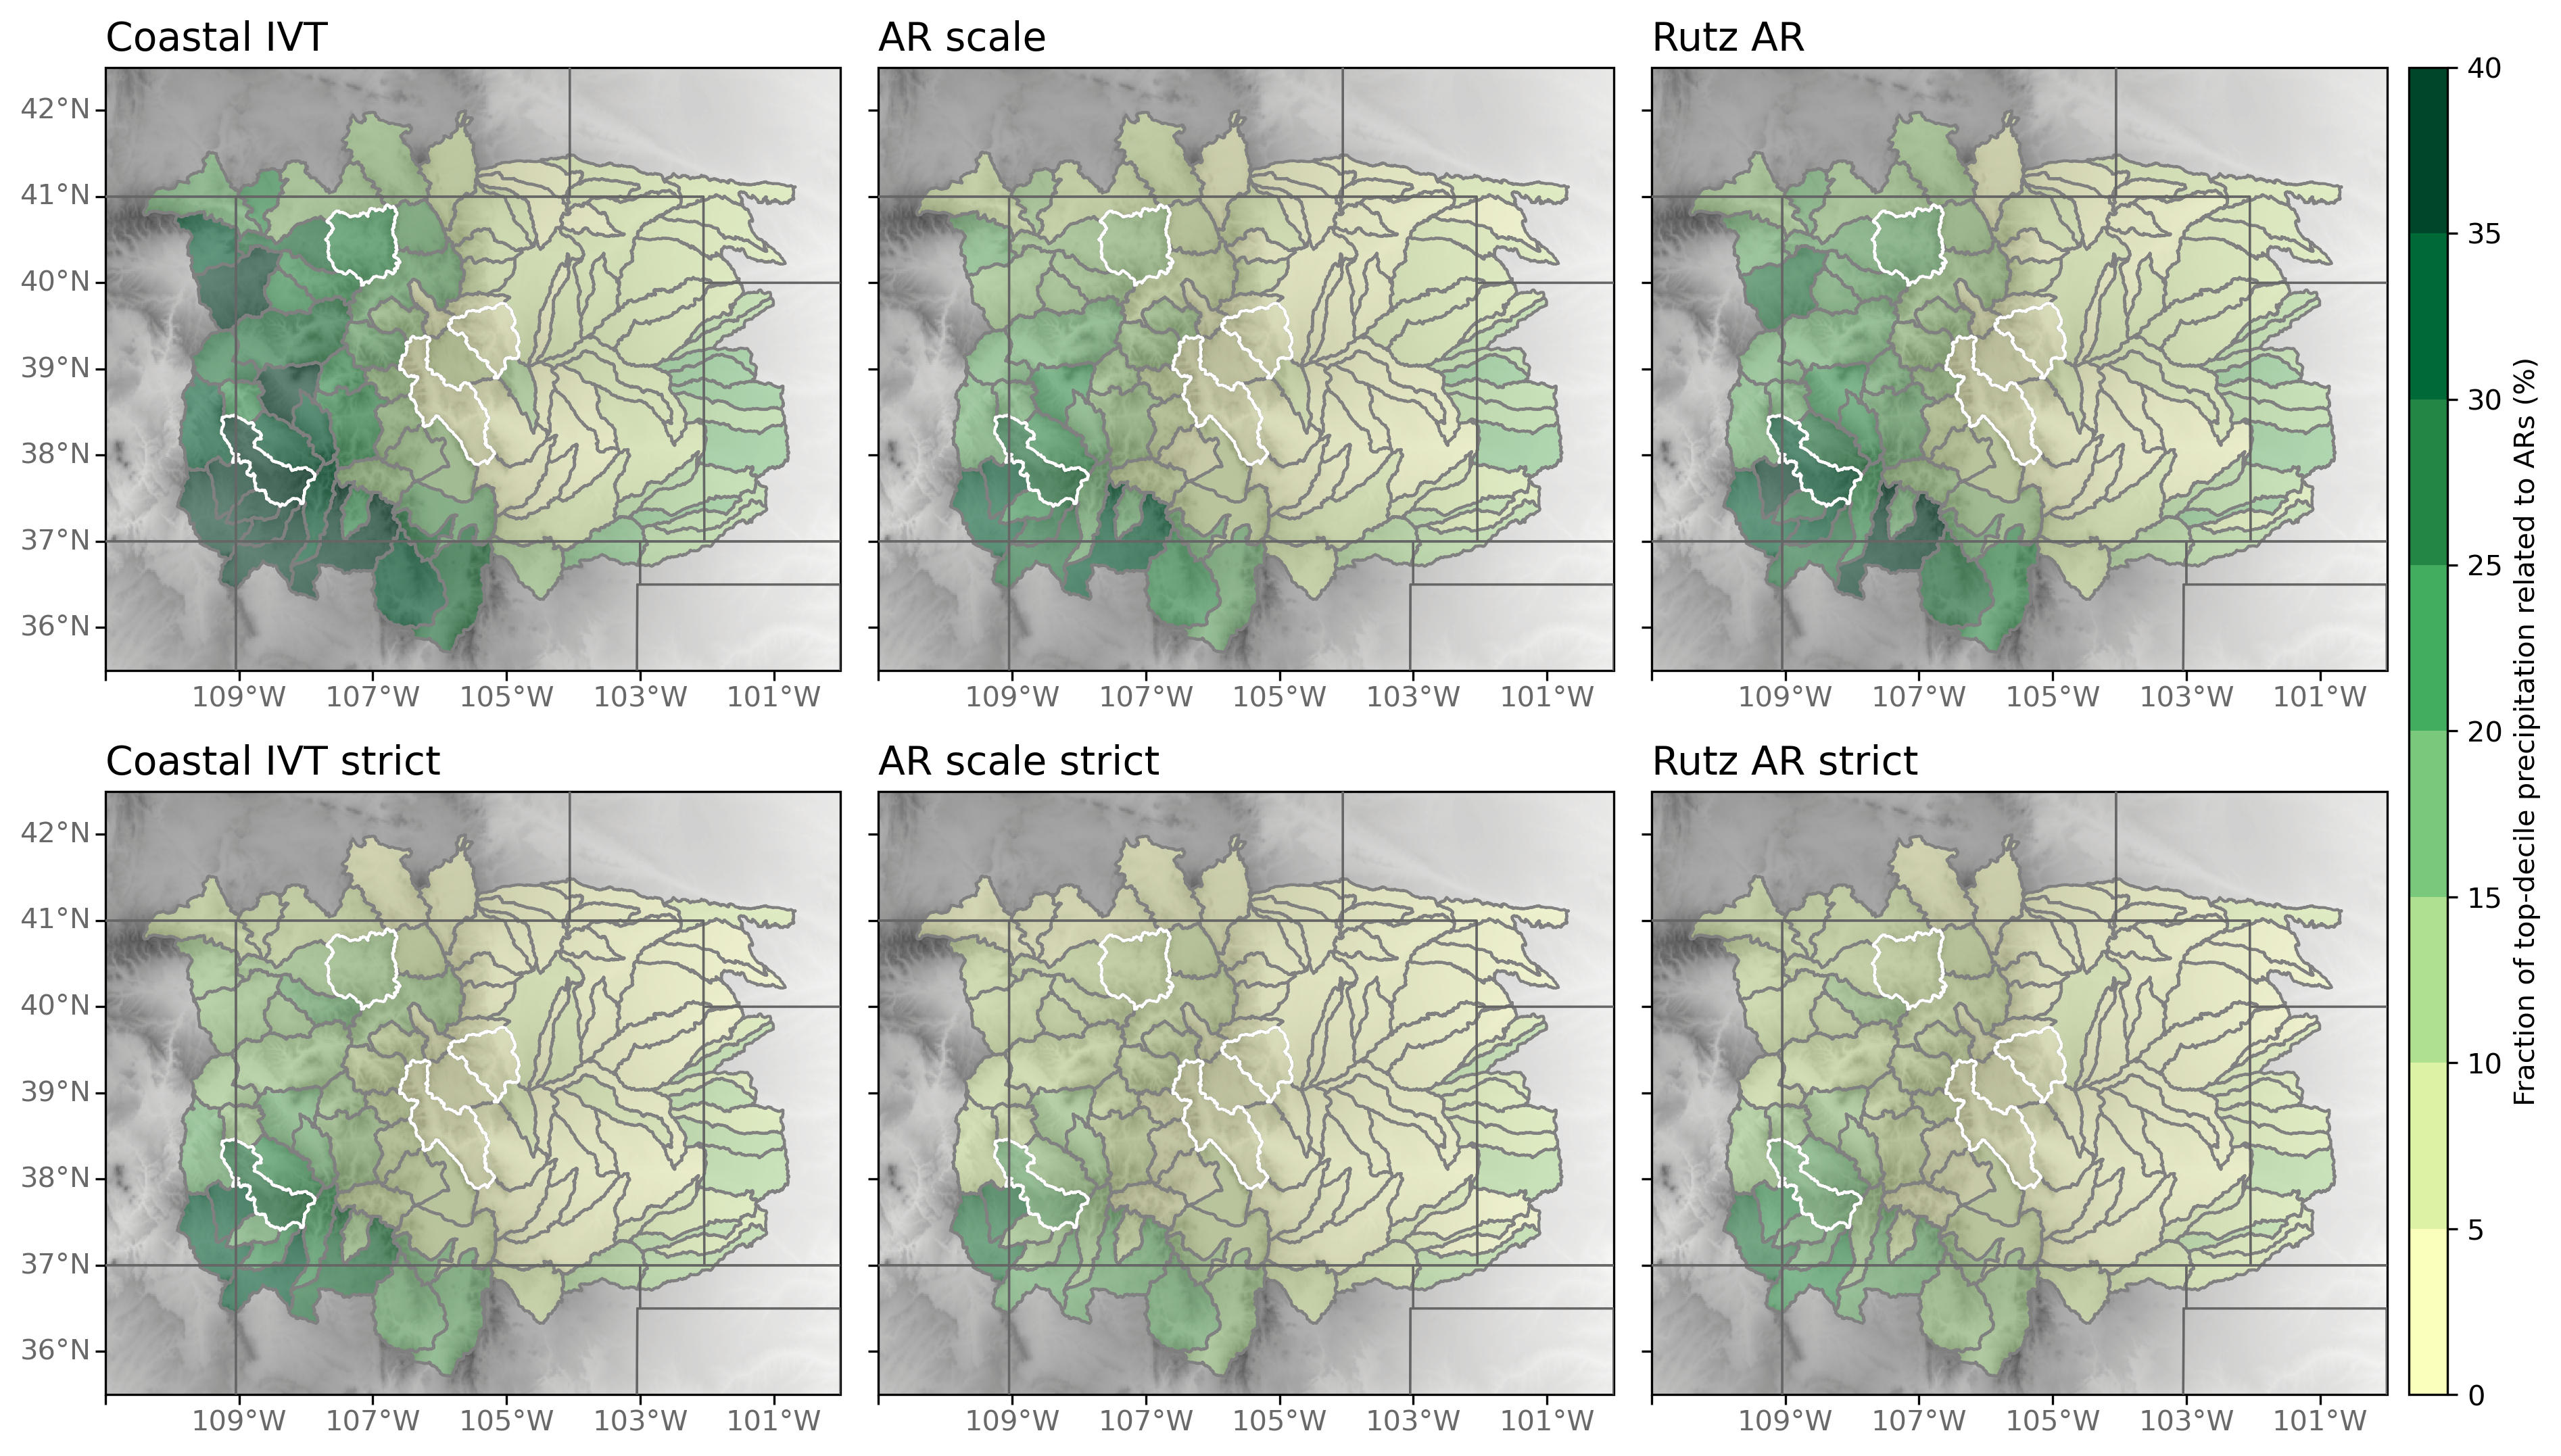

In [10]:
# Create figure
fig = plt.figure(figsize=(15, 8.5))
fig.dpi = 300
fname = path_to_figs + 'elevation_7.5_choropleth_map'
fmt = 'png'

nrows = 2
ncols = 4

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1], width_ratios = [1, 1, 1, 0.05], wspace=0.01, hspace=0.2)
## use gs[rows index, columns index] to access grids

# Add color bar axis
cbax = plt.subplot(gs[:,-1]) # colorbar axis
lbl_lst = ['Coastal IVT', 'Coastal IVT strict', 'AR scale', 'AR scale strict', 'Rutz AR', 'Rutz AR strict']
row_idx = [0, 1, 0, 1, 0, 1]
col_idx = [0, 0, 1, 1, 2, 2]
llats_lst = [True, True, False, False, False, False]

for k, varname in enumerate(var_lst):
    ## Add axis for plot
    ax = fig.add_subplot(gs[row_idx[k],col_idx[k]], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,left_lats=llats_lst[k], right_lats=False, mask_ocean=False, coastline=False)

    ## topo with gray shading
    cs = plot_terrain(ax, ext1)

    # add choropleth watershed fraction
    lgnd_kwds={"label": "Fraction of top-decile precipitation related to ARs (%)", "orientation": "vertical"}
    cmap, norm, bnds = ccmap.cmap('mclimate')
    cf = polys.plot(ax=ax, column=varname, cmap=cmap, vmin=0, vmax=40, norm=norm, alpha=0.5, legend=True, cax=cbax, legend_kwds=lgnd_kwds)
    polys.plot(ax=ax, edgecolor='grey', color='None', zorder=98)

    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8, zorder=199)

    ## add in four focus watersheds
    tmp.plot(ax=ax, edgecolor='white', color='None', zorder=99)
    # basin.plot(ax=ax, edgecolor='white', color='None', zorder=99)

    ax.set_title(lbl_lst[k], loc='left', fontsize=14)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()

In [11]:
AR_scale_lst_final

[<xarray.DataArray 'ar' (ar_scale: 6)>
 array([1425.,  235.,  222.,  264.,  136.,   36.])
 Coordinates:
   * ar_scale  (ar_scale) float64 0.0 1.0 2.0 3.0 4.0 5.0,
 <xarray.DataArray 'ar' (ar_scale: 6)>
 array([1425.,  235.,  222.,  264.,  136.,   36.])
 Coordinates:
   * ar_scale  (ar_scale) float64 0.0 1.0 2.0 3.0 4.0 5.0,
 <xarray.DataArray 'ar' (ar_scale: 6)>
 array([1419.,  235.,  222.,  264.,  136.,   36.])
 Coordinates:
   * ar_scale  (ar_scale) float64 0.0 1.0 2.0 3.0 4.0 5.0,
 <xarray.DataArray 'ar' (ar_scale: 6)>
 array([1407.,  235.,  221.,  264.,  136.,   36.])
 Coordinates:
   * ar_scale  (ar_scale) float64 0.0 1.0 2.0 3.0 4.0 5.0,
 <xarray.DataArray 'ar' (ar_scale: 6)>
 array([1425.,  235.,  222.,  264.,  136.,   36.])
 Coordinates:
   * ar_scale  (ar_scale) float64 0.0 1.0 2.0 3.0 4.0 5.0,
 <xarray.DataArray 'ar' (ar_scale: 6)>
 array([1410.,  234.,  221.,  263.,  135.,   36.])
 Coordinates:
   * ar_scale  (ar_scale) float64 0.0 1.0 2.0 3.0 4.0 5.0]